# Perform an image segmentation and filter and save selected polygons

**What does this notebook do?** This notebook performs an image segmentation to generate a polygon set from an input raster. We are using the [image segmentation module](https://www.rsgislib.org/rsgislib_segmentation.html) provided with the [RSGISLib python package](https://www.rsgislib.org/index.html). This package uses the segmentation algorithm of Shepherd et al. (2014), to segment an input `.kea` file. 

In it's current form, this workflow cheats by using `GDAL` functions at the command line. In the future, these could be changed to take advantage of the python wrappers for these functions.

We use the [`rasterstats` python package](https://pythonhosted.org/rasterstats/index.html) to calculate zonal statistics for each polygon. This package allows this to be done in a single line of code. Here we only calculate the mean value of each polygon, but additional stats can be calculated if required.

Finally, the segmented polygon set is filtered based on our requirements. In this example, we only choose to keep polygons where the average maximum NDVI value for the polygon is >= 0.8. The filtered polygon set is then saved to a shapefile.

**Requirements**. 
* This code requires the `GDAL` library to be loaded into the environment. On the NCI, if you have loaded the `DEA` modules prior to starting this notebook, `GDAL` will be included in the imported libraries. 
* We also require the `rasterstats` python library. This is not currently part of the `DEA` library and so needs to be installed by the user. To do this, type `pip install rasterstats --user` from a terminal window on the VDI. The dependencies of this library do not interfere with the `DEA` libraries.

**Date:** May 2018

**Author:** Claire Krause

In [1]:
%pylab notebook

import rsgislib
from rsgislib.segmentation import segutils
from rsgislib.rastergis import ratutils
from rasterstats import zonal_stats
from descartes import PolygonPatch
import matplotlib.cm as cm
import matplotlib.colors as colors
import fiona
import json
from fiona.crs import from_epsg
from shapely.geometry import Polygon, shape

Populating the interactive namespace from numpy and matplotlib


/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Set up the required input and output file names for this script

In [2]:
# year = '2017'
# nyear = int(year[-2:]) + 1

# This is the .tif file to be segmented
InputNDVIStats = '/g/data/r78/rjd547/groundwater_activities/Burdekin/SegTest/TCI_UB_dry_2013_ls8_grn_700_sml.tif'

# These are interim outputs for this workflow
KEAFile = '/g/data/r78/rjd547/groundwater_activities/Burdekin/SegTest/tcbgw_ub_dry_2013_ls8_grn_700_sml.kea'#.format(year, str(nyear))
SegmentedKEAFile = '/g/data/r78/rjd547/groundwater_activities/Burdekin/SegTest/tcbgw_ub_dry_2013_ls8_grn_700_ShepherdSeg_Cl20_sml.kea'#.format(year, str(nyear))
SegmentedTiffFile = '/g/data/r78/rjd547/groundwater_activities/Burdekin/SegTest/tcbgw_ub_dry_2013_ls8_grn_700_ShepherdSeg_Cl20_sml.tiff'#.format(year, str(nyear))
SegmentedPolygons = '/g/data/r78/rjd547/groundwater_activities/Burdekin/SegTest/tcbgw_ub_dry_2013_ls8_grn_700_sml'#.format(year, str(nyear))

# Figure output of the final polygons
PolygonPic = '/g/data/r78/rjd547/groundwater_activities/Burdekin/SegTest/PolygonFiltering_sml.jpg'#.format(year, str(nyear))

# This is the final output polygon set
IrrigatedPolygonShp = '/g/data/r78/rjd547/groundwater_activities/Burdekin/SegTest/thing_sml.shp'#.format(year, str(nyear))

## Create a .kea file for the image segmentation package
The image segmentation package requires a `.kea` file as an input. We are using `gdal_translate` from the command line to translate a `.tiff` file to a `.kea` file. 

*N.B This command works with a `.tiff` file with a single input band. It has yet to be tested for a `.tiff` file containing multiple bands.*

In [3]:
!gdal_translate -of KEA -a_srs EPSG:3577 $InputNDVIStats $KEAFile

Input file size is 4067, 2020
0...10...20...30...40...50...60...70...80...90...100 - done.


## Run the image segmentation with RSGISLib

The `segutils.runShepherdSegmentation` function allows a reasonable degree of tuning, based on the requirements of the user. The default configuration is shown here:

```
segutils.runShepherdSegmentation(inputImg, outputClumps, outputMeanImg=None, tmpath='.', gdalformat='KEA', 
                                 noStats=False, noStretch=False, noDelete=False, numClusters=60, minPxls=100,                   
                                 distThres=100, bands=None, sampling=100, kmMaxIter=200, processInMem=False, 
                                 saveProcessStats=False, imgStretchStats='', kMeansCentres='', 
                                 imgStatsJSONFile='')
                                 ```
The key parameters for this function are:
- `inputImg`: string containing the name of the input .kea file
- `outputClumps`: string containing the name of the output .kea file
- `numClusters`: int which specifies the number of clusters within the KMeans clustering (default = 60)
- `minPxls`: int which specifies the minimum number pixels within a segments (default = 100)
- `distThres`: the distance threshold for joining the segments (default = 100)
- `sampling`: subsampling of the image for the data used within the KMeans (default = 100; 1 = no subsampling)
- `kMaxIter`: maximum iterations for KMeans

See the [function documentation](https://www.rsgislib.org/rsgislib_segmentation.html) for additional parameter descriptions.

More information about the segmentation method is available in the following paper:

Daniel Clewley, Peter Bunting, James Shepherd, Sam Gillingham, Neil Flood, John Dymond, Richard Lucas, John Armston and Mahta Moghaddam. 2014. A Python-Based Open Source System for Geographic Object-Based Image Analysis (GEOBIA) Utilizing Raster Attribute Tables. Remote Sensing. Volume 6, Pages 6111-6135. http://www.mdpi.com/2072-4292/6/7/6111

**For finding crop field polygons, we use 20 clusters, and 200 minimum pixels. All other options are left as default**

In [4]:
segutils.runShepherdSegmentation(KEAFile, SegmentedKEAFile, numClusters=60, minPxls = 20)

Stretch Input Image
Add 1 to stretched file to ensure there are no all zeros (i.e., no data) regions created.
Create Input Image Mask.
Mask stretched Image.
Deleting file: ./tcbgw_ub_dry_2013_ls8_grn_700_sml_stchdonly.kea
Deleting file: ./tcbgw_ub_dry_2013_ls8_grn_700_sml_stchdonlyOff.kea
Deleting file: ./tcbgw_ub_dry_2013_ls8_grn_700_sml_stchdmaskonly.kea
Performing KMeans.
Apply KMeans to image.
Eliminate Single Pixels.
Perform clump.
Eliminate small pixels.
Relabel clumps.
Calculate image statistics and build pyramids.
Deleting file: ./tcbgw_ub_dry_2013_ls8_grn_700_sml_kmeansclusters.gmtxt
Deleting file: ./tcbgw_ub_dry_2013_ls8_grn_700_sml_kmeans.kea
Deleting file: ./tcbgw_ub_dry_2013_ls8_grn_700_sml_kmeans.kea.aux.xml
Deleting file: ./tcbgw_ub_dry_2013_ls8_grn_700_sml_kmeans_nosgl.kea
Deleting file: ./tcbgw_ub_dry_2013_ls8_grn_700_sml_kmeans_nosglTMP.kea
Deleting file: ./tcbgw_ub_dry_2013_ls8_grn_700_sml_clumps.kea
Deleting file: ./tcbgw_ub_dry_2013_ls8_grn_700_sml_clumps_elim.kea


### Viewing the output .kea file
This can be done within a program called [`TuiView`](https://bitbucket.org/chchrsc/tuiview). To run this program, type `/g/data/v10/public/tuiview/bin/tuiview &` into a new terminal window. Basic instructions for this program can be found in the [TuiView Wiki](https://bitbucket.org/chchrsc/tuiview/wiki/Home). You can drag and drop the file into this program from the `File Browser`, and interrogate the attribute table using the `Query Tool`.

## Translate back from .kea to .tif to make the file easier to work with

In [5]:
!gdal_translate -of GTIFF -a_srs EPSG:3577 $SegmentedKEAFile $SegmentedTiffFile

Input file size is 4067, 2020
0Warning 1: Unable to export color table to GeoTIFF file.  Color tables can only be written to 1 band or 2 bands Byte or UInt16 GeoTIFF files.
...10...20...30...40...50...60...70...80...90...100 - done.


## Save the segments from the .tif file as polygons in a shapefile

In [6]:
!gdal_polygonize.py $SegmentedTiffFile -f "ESRI Shapefile" $SegmentedPolygons MaxNDVISummer

Creating output /g/data/r78/rjd547/groundwater_activities/Burdekin/SegTest/tcbgw_ub_dry_2013_ls8_grn_700_sml of format ESRI Shapefile.
0...10...20...30...40...50...60...70...80...90...100 - done.


## Calculate zonal statistics for each polygon

This step requires the [`rasterstats` python package](https://pythonhosted.org/rasterstats/index.html).

In [7]:
polygon_stats = zonal_stats('{0}/MaxNDVISummer.shp'.format(SegmentedPolygons), InputNDVIStats, 
                            stats = 'mean', geojson_out = True, nodata = -9999)

/home/547/rjd547/.digitalearthau/20180405/local/lib/python3.6/site-packages/rasterstats/main.py:165: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  np.issubdtype(fsrc.array.dtype, float)


### And plot the mean value for each polygon

<IPython.core.display.Javascript object>


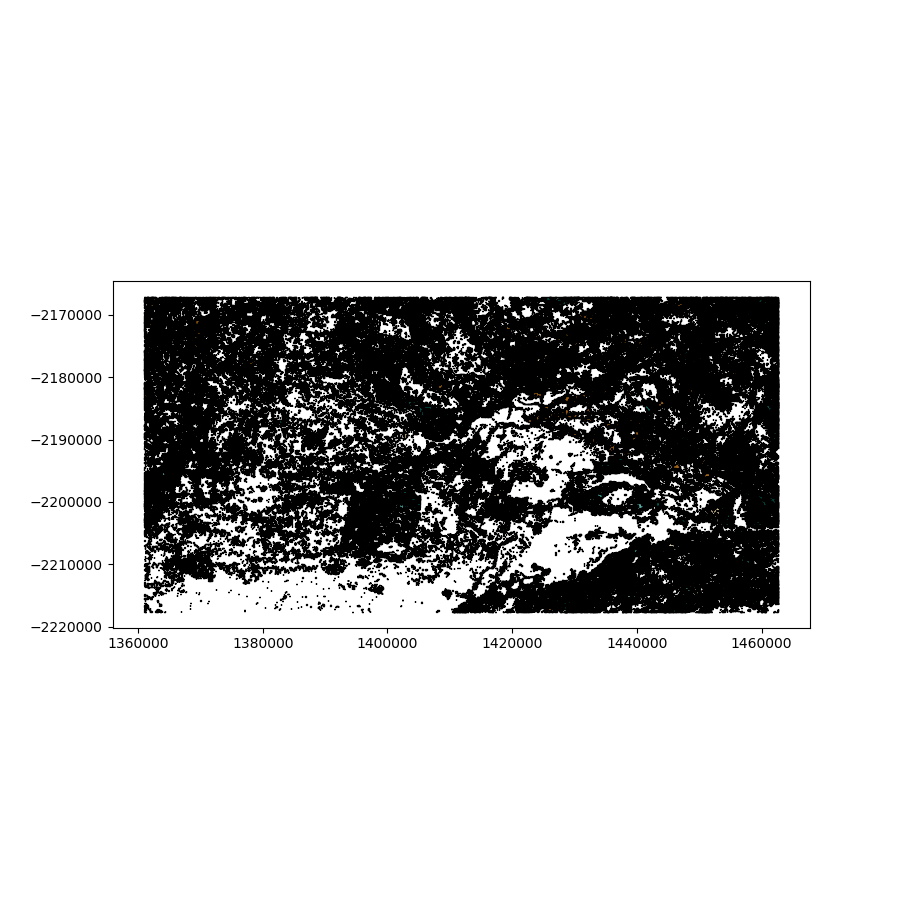

In [8]:
cmap= plt.cm.BrBG
# create normalization instance
norm = matplotlib.colors.Normalize(vmin=0, vmax=1) 
# create a scalarmappable from the colormap
sm = matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm)   
sm.set_array([])  

fig = plt.figure(figsize = [9,9])
ax = fig.gca()
for i in range(len(polygon_stats)):
    meanVal = polygon_stats[i]['properties']['mean']
    ax.add_patch(PolygonPatch(polygon_stats[i]['geometry'], facecolor = cmap(norm(meanVal))))
ax.axis('scaled')
plt.draw()
plt.show()

## Calculate the area of each polygon

In [9]:
for i in range(len(polygon_stats)):
    polyArea = Polygon(polygon_stats[i]['geometry']['coordinates'][0]).area
    polygon_stats[i]['properties']['area'] = polyArea

## Select only polygons where the mean max NDVI is >= 0.8

In [ ]:
MeanValues = [polygon_stats[i]['properties']['mean'] for i in range(len(polygon_stats))]
MeanValuesIndex = [i for i, x in enumerate(MeanValues) if x >= 0.8]
IrrigatedPolygons = [polygon_stats[x] for x in MeanValuesIndex]

## And where the polygon area is less than 5,500,000 m2 (5.5 km2)
(number chosen based on a judgement call of valid vs not-useful polygons)

In [ ]:
Areas = [IrrigatedPolygons[i]['properties']['area'] for i in range(len(IrrigatedPolygons))]
AreasIndex = [i for i, x in enumerate(Areas) if x < 5500000]
SmallIrrigatedPolygons = [IrrigatedPolygons[x] for x in AreasIndex]

## And remove any polygons that overlap with a major river
To remove erroneous riperian polygons, using [The Surface Hydrology Lines (Regional)](http://pid.geoscience.gov.au/dataset/ga/83107) dataset (2015) from Geoscience Australia. 

In [ ]:
import geopandas as gp
from geopandas.tools import sjoin
MajorRivers = gp.GeoDataFrame.from_file('/g/data/r78/cek156/dea-notebooks/SurfaceHydrologyLinesRegionalFilteredMAJOR.shp') 

# Grab the geometeries
for poly in SmallIrrigatedPolygons:
    poly['geometryold'] = poly['geometry']
    poly['geometry'] = shape(poly['geometry'])
    
IrrigatedPolygons2p0 = gp.GeoDataFrame(SmallIrrigatedPolygons).set_geometry('geometry')
Intersections= gp.sjoin(MajorRivers, IrrigatedPolygons2p0, how="inner", op='intersects')
IntersectIndex = sorted(list(set(Intersections['index_right'])))

SmallFilteredIrrigatedPolygons = [SmallIrrigatedPolygons[x] for x in range(len(SmallIrrigatedPolygons)) 
                                  if x not in IntersectIndex]

### And plot our filtered polygon set

In [ ]:
cmap= plt.cm.BrBG
# create normalization instance
norm = matplotlib.colors.Normalize(vmin=0, vmax=1) 
# create a scalarmappable from the colormap
sm = matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm)   
sm.set_array([])  

label1_added = False
label2_added = False
label3_added = False

fig = plt.figure(figsize = [9,9])
ax = fig.gca()
for i in range(len(IrrigatedPolygons)):
    meanVal = IrrigatedPolygons[i]['properties']['mean']
    if not label1_added:
        ax.add_patch(PolygonPatch(IrrigatedPolygons[i]['geometry'], 
                                  edgecolor = 'g', facecolor = 'g', 
                                  label = 'NDVI > 0.8'))
        label1_added = True
    else:
        ax.add_patch(PolygonPatch(IrrigatedPolygons[i]['geometry'], 
                                  edgecolor = 'g', facecolor = 'g'))
for i in range(len(SmallIrrigatedPolygons)):      
    meanVal = SmallIrrigatedPolygons[i]['properties']['mean']
    if not label2_added:  
        ax.add_patch(PolygonPatch(SmallIrrigatedPolygons[i]['geometry'], 
                                  edgecolor = 'dodgerblue', facecolor = 'dodgerblue',
                                  label = 'NDVI + smaller than 5.5km2'))
        label2_added = True
    else:
        ax.add_patch(PolygonPatch(SmallIrrigatedPolygons[i]['geometry'], 
                                  edgecolor = 'dodgerblue', facecolor = 'dodgerblue'))
for i in range(len(SmallFilteredIrrigatedPolygons)):
    meanVal = SmallFilteredIrrigatedPolygons[i]['properties']['mean']
    if not label3_added:
        ax.add_patch(PolygonPatch(SmallFilteredIrrigatedPolygons[i]['geometry'], 
                                  edgecolor = 'crimson', facecolor = 'crimson',
                                  label = 'NDVI + small + doesn\'t intersect major river'))
        label3_added = True
    else:
        ax.add_patch(PolygonPatch(SmallFilteredIrrigatedPolygons[i]['geometry'], 
                                  edgecolor = 'crimson', facecolor = 'crimson'))
ax.axis('scaled')
plt.draw()
plt.show()
plt.legend()
savefig(PolygonPic, dpi = 400)

## Export our chosen polygons to a shape file

In [19]:
schema = {'geometry': 'Polygon','properties': {'mean': 'str', 'area': 'str'}}

with fiona.open(IrrigatedPolygonShp, "w", crs = from_epsg(3577), driver = 'ESRI Shapefile', schema = schema) as output:
    for i in range(len(SmallFilteredIrrigatedPolygons)):
        output.write({'properties': {'mean': SmallFilteredIrrigatedPolygons[i]['properties']['mean'], 
                                     'area': SmallFilteredIrrigatedPolygons[i]['properties']['area']},
                    'geometry': SmallFilteredIrrigatedPolygons[i]['geometryold']})